## Data Loading

In [1]:
from datasets import load_dataset
import pandas as pd

# Load the LIAR dataset
dataset = load_dataset("liar", trust_remote_code=True)

# Access train, validation, and test splits
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

# Display dataset sizes and columns
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))
print("\nColumns:", train_df.columns.tolist())

# Define target label names
target_names = ["Pants on fire", "False", "Barely-true", "Half-true", "Mostly-true", "True"]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train size: 10269
Validation size: 1284
Test size: 1283

Columns: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']


In [2]:
print(train_df.head())

           id  label                                          statement  \
0   2635.json      0  Says the Annies List political group supports ...   
1  10540.json      1  When did the decline of coal start? It started...   
2    324.json      2  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json      0  Health care reform legislation is likely to ma...   
4   9028.json      1  The economic turnaround started at the end of ...   

                              subject         speaker             job_title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                         
4                        economy,jobs   charlie-crist                         

  state_info party_affiliation  barely_true_counts  false_counts  \
0     

## Preprocessing

In [3]:
import os
import openai
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Set your OpenAI API key
openai.api_key = ""
def prepare_text_fields(df):
    """
    Concatenate several text fields into a single string for the 'body'.
    Minimal cleaning is done here.
    """
    df = df.fillna("")  # Handle missing values
    headline_texts = (
        df["subject"].astype(str) + " " +
        df["party_affiliation"].astype(str) + " " +
        df["context"].astype(str)
    ).tolist()
    body_texts = df["statement"].astype(str).tolist()
    return headline_texts, body_texts

def get_embeddings(texts, model="text-embedding-ada-002", batch_size=1000):
    """
    Generate embeddings for a list of texts using OpenAI's API.
    
    Args:
        texts (List[str]): List of text strings to embed.
        model (str): The embedding model to use.
        batch_size (int): Number of texts to send in each API request.
        
    Returns:
        np.ndarray: Array of embeddings.
    """
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch = texts[i:i+batch_size]
        try:
            response = openai.Embedding.create(input=batch, model=model)
            batch_embeddings = [e['embedding'] for e in response['data']]
            embeddings.extend(batch_embeddings)
        except Exception as e:
            print(f"Error generating embeddings for batch {i//batch_size + 1}: {e}")
            # Handle errors (e.g., retry logic) as needed
            embeddings.extend([np.zeros(1536)] * len(batch))  # Placeholder embeddings
    return np.array(embeddings)

def compute_cosine_similarity(embA, embB):
    """
    Compute cosine similarity between two sets of embeddings.
    
    Args:
        embA (np.ndarray): Embeddings for set A.
        embB (np.ndarray): Embeddings for set B.
        
    Returns:
        np.ndarray: Cosine similarity scores.
    """
    # Normalize embeddings to unit vectors
    normA = embA / np.linalg.norm(embA, axis=1, keepdims=True)
    normB = embB / np.linalg.norm(embB, axis=1, keepdims=True)
    
    # Compute element-wise dot product
    cosine_sim = np.sum(normA * normB, axis=1)
    
    return cosine_sim.reshape(-1, 1)

def combine_features(emb_head, emb_body, cos_sim):
    """
    Combine headline embeddings, body embeddings, and cosine similarity into a single feature matrix.
    
    Args:
        emb_head (np.ndarray): Headline embeddings.
        emb_body (np.ndarray): Body embeddings.
        cos_sim (np.ndarray): Cosine similarity scores.
        
    Returns:
        np.ndarray: Combined feature matrix.
    """
    return np.hstack([emb_head, emb_body, cos_sim])

# Load your data into train_df, val_df, test_df
# Example:
# train_df = pd.read_csv("train.csv")
# val_df = pd.read_csv("val.csv")
# test_df = pd.read_csv("test.csv")

# Prepare train, val, test text
train_headlines, train_bodies = prepare_text_fields(train_df)
val_headlines,   val_bodies   = prepare_text_fields(val_df)
test_headlines,  test_bodies  = prepare_text_fields(test_df)

# Generate embeddings
train_headline_emb = get_embeddings(train_headlines)
train_body_emb     = get_embeddings(train_bodies)

val_headline_emb   = get_embeddings(val_headlines)
val_body_emb       = get_embeddings(val_bodies)

test_headline_emb  = get_embeddings(test_headlines)
test_body_emb      = get_embeddings(test_bodies)

# Compute cosine similarities
train_cos_sim = compute_cosine_similarity(train_headline_emb, train_body_emb)
val_cos_sim   = compute_cosine_similarity(val_headline_emb, val_body_emb)
test_cos_sim  = compute_cosine_similarity(test_headline_emb, test_body_emb)

# Combine features
train_X = combine_features(train_headline_emb, train_body_emb, train_cos_sim)
val_X   = combine_features(val_headline_emb, val_body_emb, val_cos_sim)
test_X  = combine_features(test_headline_emb, test_body_emb, test_cos_sim)

# Encode labels
label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_df["label"].tolist())
val_y   = label_encoder.transform(val_df["label"].tolist())
test_y  = label_encoder.transform(test_df["label"].tolist())

print("Feature shape (train):", train_X.shape)
print("Feature shape (val):", val_X.shape)
print("Feature shape (test):", test_X.shape)
print("Labels:", list(label_encoder.classes_))


Generating embeddings: 100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


Feature shape (train): (10269, 3073)
Feature shape (val): (1284, 3073)
Feature shape (test): (1283, 3073)
Labels: [0, 1, 2, 3, 4, 5]


## Single-Layer MLP Classifier

In [5]:
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
import numpy as np

# Assuming train_X, val_X, test_X are already defined as NumPy arrays
# and label_encoder is already fitted.

# Hyperparameters from the paper (roughly)
hidden_size = 100
dropout_rate = 0.6
l2_alpha = 1e-4
learning_rate = 1e-2
batch_size = 500
epochs = 100  # Increased epochs to allow early stopping to decide when to stop

# Ensure that train_X, val_X, and test_X are NumPy arrays
# and convert them to float32 if they aren't already
train_X_array = train_X.astype('float32')  # No tocsr() needed
val_X_array   = val_X.astype('float32')
test_X_array  = test_X.astype('float32')

# Determine the number of features and classes
num_features = train_X_array.shape[1]
num_classes = len(label_encoder.classes_)

print(f"Number of features: {num_features}")
print(f"Number of classes: {num_classes}")

# Build the model
model = keras.Sequential([
    # Input layer
    keras.layers.InputLayer(input_shape=(num_features,)),
    
    # Hidden layer
    keras.layers.Dense(
        hidden_size, 
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(l2_alpha)
    ),
    keras.layers.Dropout(dropout_rate),
    
    # Output layer
    keras.layers.Dense(
        num_classes, 
        activation='softmax',
        kernel_regularizer=keras.regularizers.l2(l2_alpha)
    )
])

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_y),
    y=train_y
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model.keras',  # Changed extension to .keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,  # Factor by which the learning rate will be reduced
    patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,
    min_lr=1e-6  # Lower bound on the learning rate
)

# Train the model with class weights and callbacks
history = model.fit(
    train_X_array, train_y,
    validation_data=(val_X_array, val_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Load the best model weights
model.load_weights('best_model.keras')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_X_array, test_y, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")


Number of features: 3073
Number of classes: 6
Class Weights: {0: 0.8566066066066066, 1: 0.8061705134243994, 2: 0.8705493387589013, 3: 1.016934046345811, 4: 1.0328907664453832, 5: 2.0326603325415675}
Epoch 1/100
15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1888 - loss: 1.8345 
Epoch 1: val_loss improved from inf to 1.75957, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1908 - loss: 1.8268 - val_accuracy: 0.2438 - val_loss: 1.7596 - learning_rate: 0.0100
Epoch 2/100
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2138 - loss: 1.7544
Epoch 2: val_loss improved from 1.75957 to 1.73901, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2138 - loss: 1.7555 - val_accuracy: 0.2290 - val_loss: 1.7390 - learning_rate: 0.0100
Epoch 3/100
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2113 - loss: 1.7427
Epoch 3: val_loss improved from 1.73901 to 1.71862, saving model to best_model.keras
21/21 ━━━━━━━━

In [6]:
import numpy as np

test_probs = model.predict(test_X_array)  # shape [n_samples, num_classes]
test_preds = np.argmax(test_probs, axis=1)  # integer labels


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


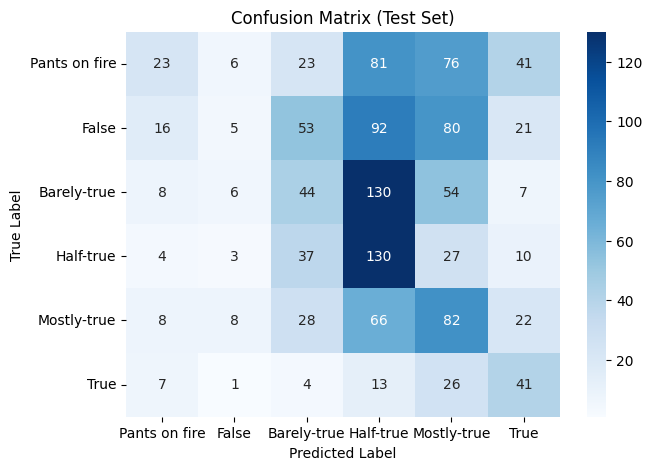

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_y, test_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=target_names, 
            yticklabels=target_names, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [8]:
from sklearn.metrics import accuracy_score
print("Test Accuracy (sklearn):", accuracy_score(test_y, test_preds))


Test Accuracy (sklearn): 0.2533125487139517


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr_model = LogisticRegression(max_iter=1000)  # or tune as you wish
lr_model.fit(train_X, train_y)  # can fit directly on the sparse matrix
lr_preds = lr_model.predict(test_X)

print(classification_report(test_y, lr_preds, target_names=target_names))

# For top features (e.g., for label i) 
# The shape of lr_model.coef_ is [num_classes, num_features]
coef_array = lr_model.coef_
for idx, label_name in enumerate(target_names):
    top10_idx = np.argsort(coef_array[idx])[-10:]      # largest positive 10
    top10_feats = [str(i) for i in top10_idx]
    print(f"Top 10 features for label {label_name}: {top10_feats}")


               precision    recall  f1-score   support

Pants on fire       0.32      0.40      0.35       250
        False       0.29      0.34      0.31       267
  Barely-true       0.28      0.30      0.29       249
    Half-true       0.29      0.29      0.29       211
  Mostly-true       0.35      0.20      0.25       214
         True       0.46      0.25      0.32        92

     accuracy                           0.31      1283
    macro avg       0.33      0.30      0.30      1283
 weighted avg       0.31      0.31      0.30      1283

Top 10 features for label Pants on fire: ['1599', '2522', '2425', '2046', '2660', '2624', '2539', '2079', '1645', '1700']
Top 10 features for label False: ['1960', '1844', '1761', '2887', '2797', '1549', '2198', '2509', '2264', '2591']
Top 10 features for label Barely-true: ['2710', '2899', '2561', '2394', '2633', '2509', '2264', '2473', '2954', '1622']
Top 10 features for label Half-true: ['2960', '2781', '2755', '1648', '2844', '2942', '2106

In [10]:
# After training
train_loss, train_acc = model.evaluate(train_X_array, train_y, verbose=0)
val_loss, val_acc = model.evaluate(val_X_array, val_y, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Training Accuracy: 0.2833
Validation Accuracy: 0.2539


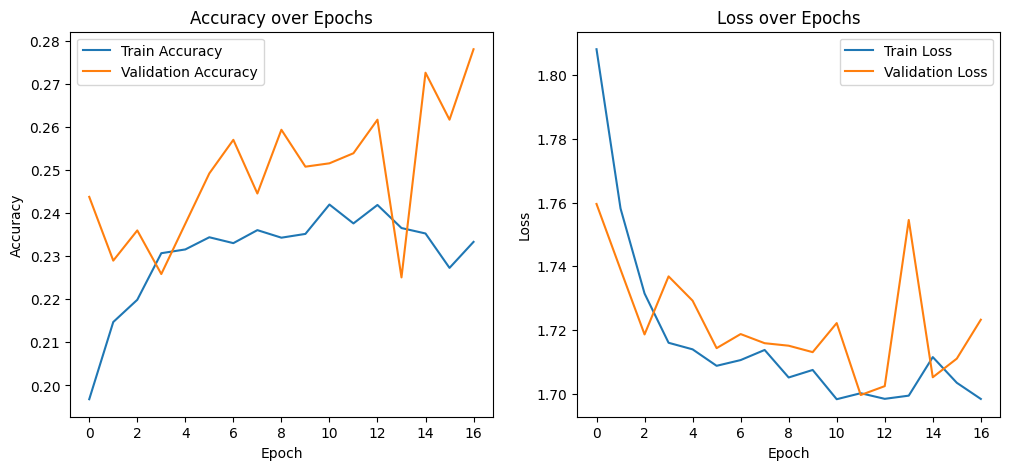

In [11]:
import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned by model.fit()
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Cross Validation

Class Weights: {0: 0.8566066066066066, 1: 0.8061705134243994, 2: 0.8705493387589013, 3: 1.016934046345811, 4: 1.0328907664453832, 5: 2.0326603325415675}

Training for fold 1 ...
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1909 - loss: 2.3957 - val_accuracy: 0.2235 - val_loss: 1.9628 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2524 - loss: 1.8798 - val_accuracy: 0.2313 - val_loss: 1.8180 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2809 - loss: 1.7337 - val_accuracy: 0.2410 - val_loss: 1.7761 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3186 - loss: 1.6280 - val_accuracy: 0.2634 - val_loss: 1.7508 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3384 - loss: 1.5664 - val_accuracy: 0.2488 - val_loss: 1.7616 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3736 - loss: 1.5059 - val_accuracy: 0.2619 - val_loss: 1.7509 - learning_rate: 0.0010
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3852 - loss: 1.4665 - val_accuracy: 0.26

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1948 - loss: 2.3884 - val_accuracy: 0.2113 - val_loss: 1.9868 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2626 - loss: 1.8577 - val_accuracy: 0.2259 - val_loss: 1.8326 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2950 - loss: 1.7227 - val_accuracy: 0.2347 - val_loss: 1.8023 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3295 - loss: 1.6267 - val_accuracy: 0.2502 - val_loss: 1.7974 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3374 - loss: 1.5574 - val_accuracy: 0.2527 - val_loss: 1.7818 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3625 - loss: 1.4857 - val_accuracy: 0.2614 - val_loss: 1.7909 - learning_rate: 0.0010
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3983 - loss: 1.4341 - val_accuracy: 0.260

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1842 - loss: 2.3643 - val_accuracy: 0.2196 - val_loss: 1.9190 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2547 - loss: 1.8561 - val_accuracy: 0.2390 - val_loss: 1.8047 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2946 - loss: 1.6960 - val_accuracy: 0.2639 - val_loss: 1.7643 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3149 - loss: 1.6318 - val_accuracy: 0.2687 - val_loss: 1.7492 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3411 - loss: 1.5567 - val_accuracy: 0.2824 - val_loss: 1.7379 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3697 - loss: 1.4990 - val_accuracy: 0.2843 - val_loss: 1.7349 - learning_rate: 0.0010
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3783 - loss: 1.4484 - val_accuracy: 0.279

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1912 - loss: 2.3990 - val_accuracy: 0.2278 - val_loss: 1.9766 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2593 - loss: 1.8413 - val_accuracy: 0.2459 - val_loss: 1.8193 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2906 - loss: 1.7431 - val_accuracy: 0.2498 - val_loss: 1.7711 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3318 - loss: 1.6312 - val_accuracy: 0.2619 - val_loss: 1.7481 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3529 - loss: 1.5493 - val_accuracy: 0.2668 - val_loss: 1.7336 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3813 - loss: 1.5019 - val_accuracy: 0.2722 - val_loss: 1.7339 - learning_rate: 0.0010
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4025 - loss: 1.4415 - val_accuracy: 0.271

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1935 - loss: 2.3704 - val_accuracy: 0.2094 - val_loss: 2.1245 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2565 - loss: 1.8697 - val_accuracy: 0.2338 - val_loss: 1.8600 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2887 - loss: 1.7378 - val_accuracy: 0.2479 - val_loss: 1.7797 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3291 - loss: 1.6229 - val_accuracy: 0.2669 - val_loss: 1.7509 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3419 - loss: 1.5577 - val_accuracy: 0.2694 - val_loss: 1.7513 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3596 - loss: 1.5235 - val_accuracy: 0.2684 - val_loss: 1.7589 - learning_rate: 0.0010
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4034 - loss: 1.4447 - val_accuracy: 0.26

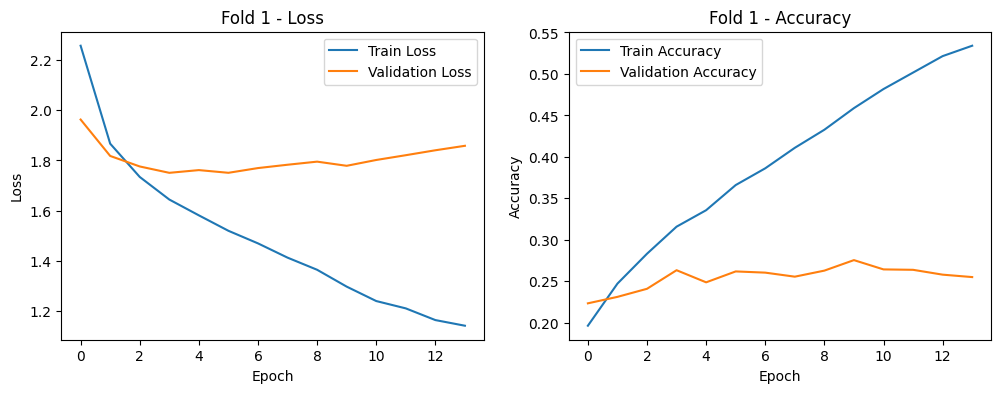

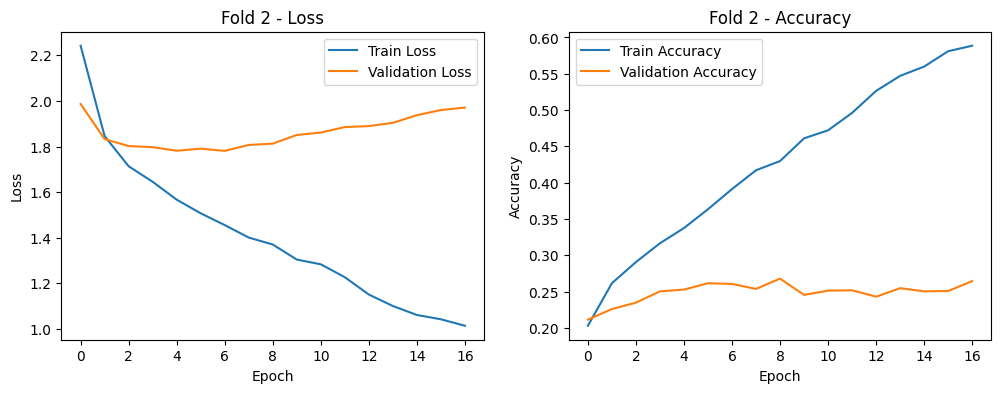

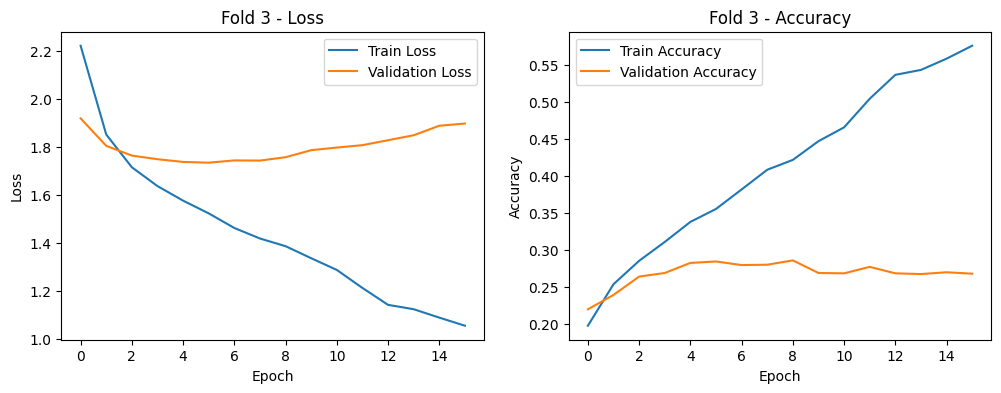

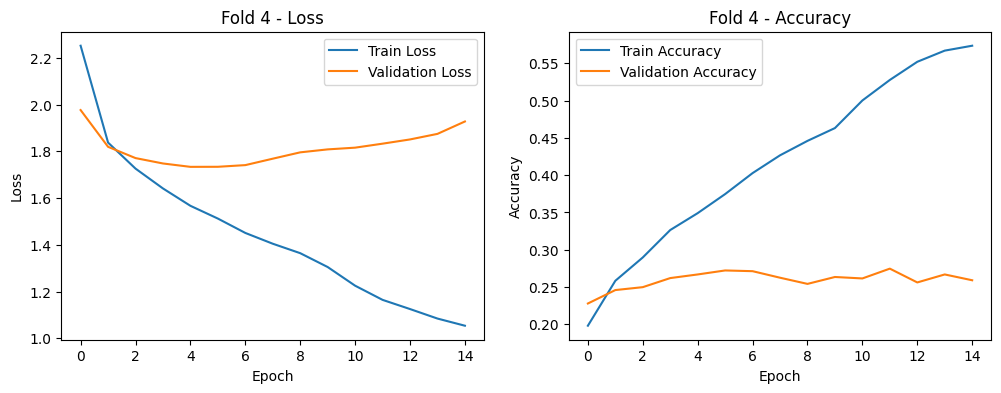

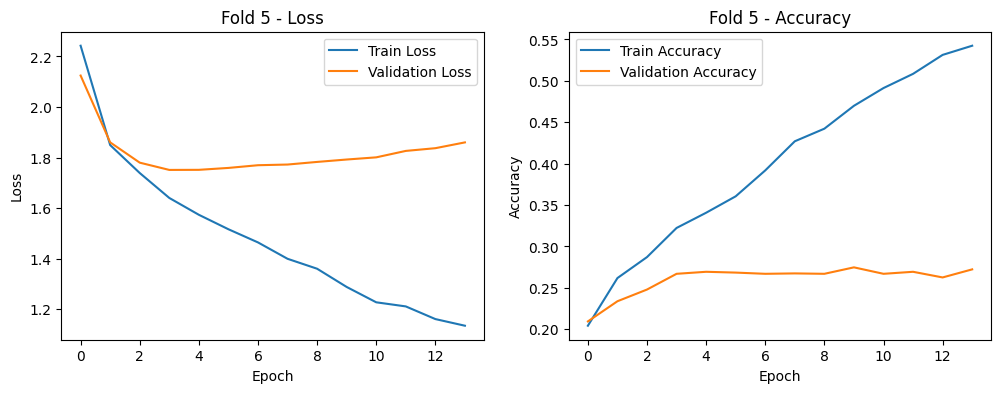

/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_13125/1657339638.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Accuracy', data=metrics_df, palette='pastel')


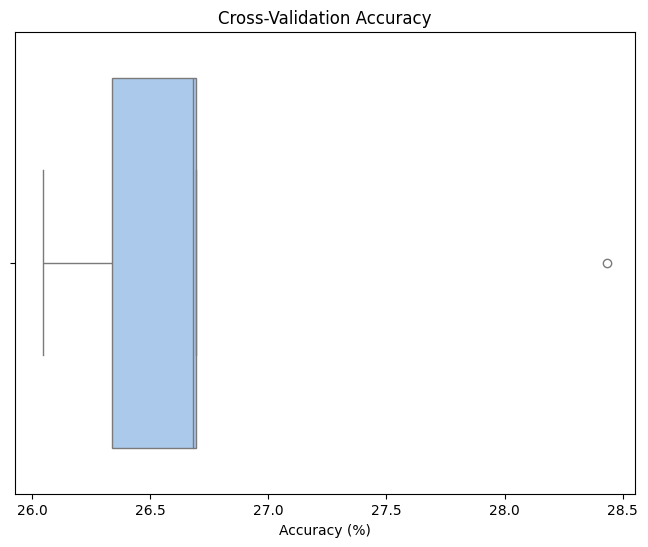

/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_13125/1657339638.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Loss', data=metrics_df, palette='muted')


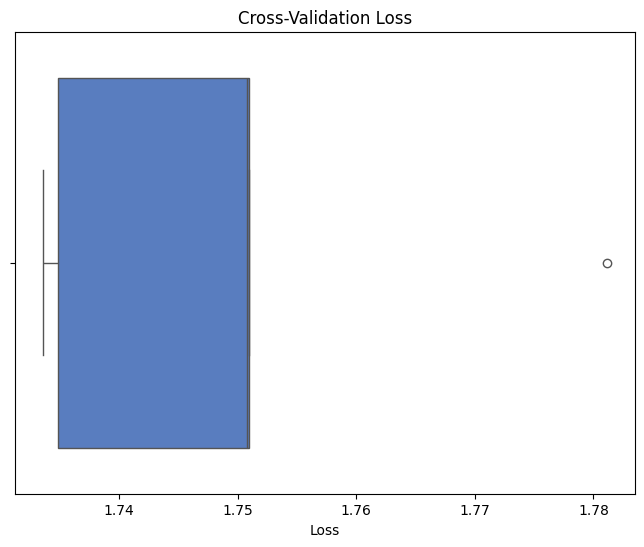

/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_13125/1657339638.py:183: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Fold', y='Accuracy', data=metrics_df, ci='sd', palette='viridis')
/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_13125/1657339638.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Fold', y='Accuracy', data=metrics_df, ci='sd', palette='viridis')


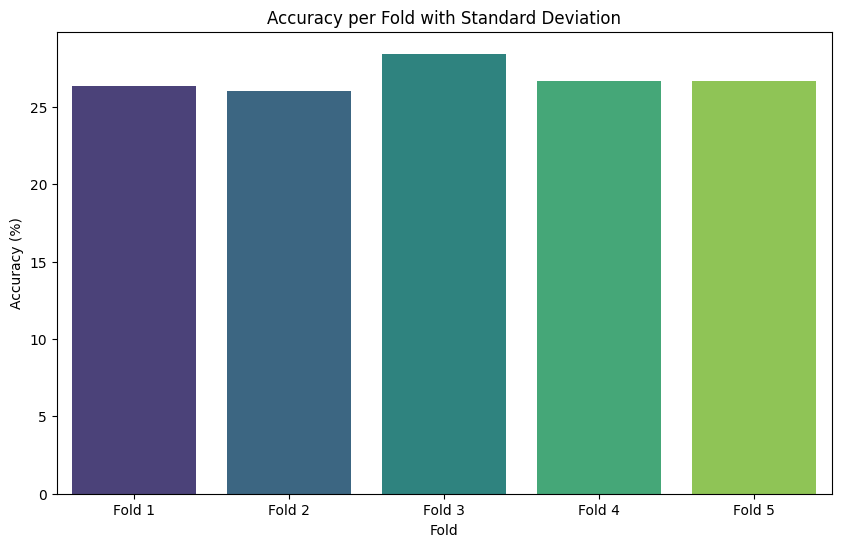

/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_13125/1657339638.py:191: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Fold', y='Loss', data=metrics_df, ci='sd', palette='magma')
/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_13125/1657339638.py:191: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Fold', y='Loss', data=metrics_df, ci='sd', palette='magma')


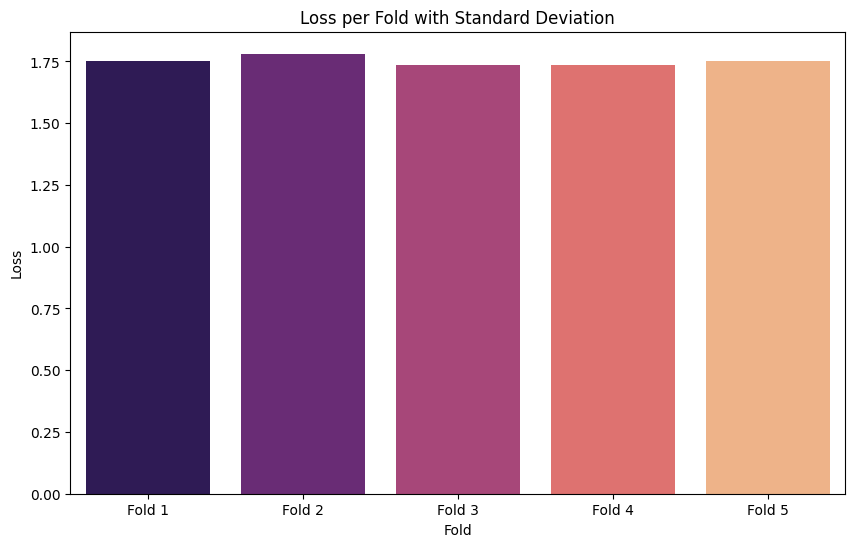


Generating confusion matrix for Fold 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


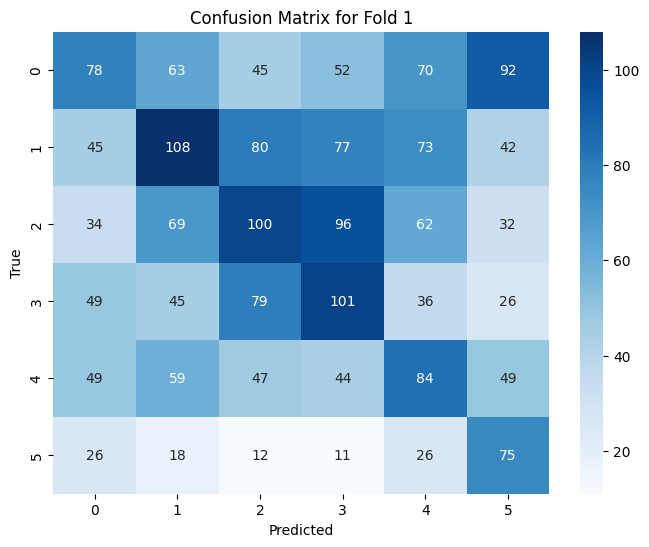

Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       0.28      0.20      0.23       400
           1       0.30      0.25      0.27       425
           2       0.28      0.25      0.26       393
           3       0.27      0.30      0.28       336
           4       0.24      0.25      0.25       332
           5       0.24      0.45      0.31       168

    accuracy                           0.27      2054
   macro avg       0.27      0.28      0.27      2054
weighted avg       0.27      0.27      0.26      2054


Generating confusion matrix for Fold 2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


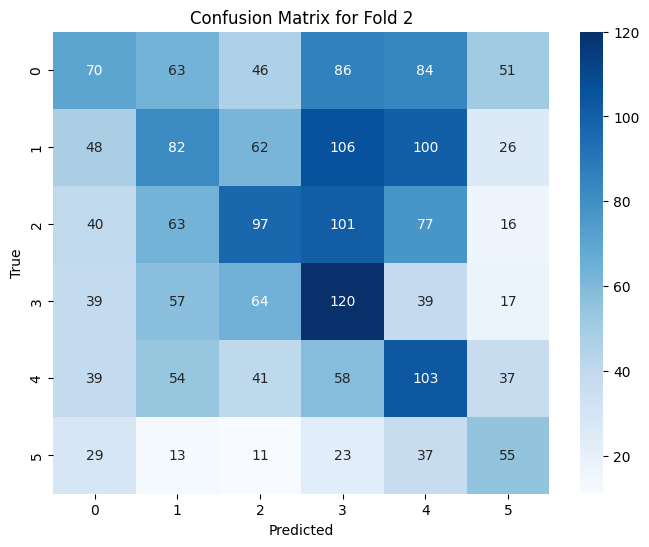

Classification Report for Fold 2:
              precision    recall  f1-score   support

           0       0.26      0.17      0.21       400
           1       0.25      0.19      0.22       424
           2       0.30      0.25      0.27       394
           3       0.24      0.36      0.29       336
           4       0.23      0.31      0.27       332
           5       0.27      0.33      0.30       168

    accuracy                           0.26      2054
   macro avg       0.26      0.27      0.26      2054
weighted avg       0.26      0.26      0.25      2054


Generating confusion matrix for Fold 3


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


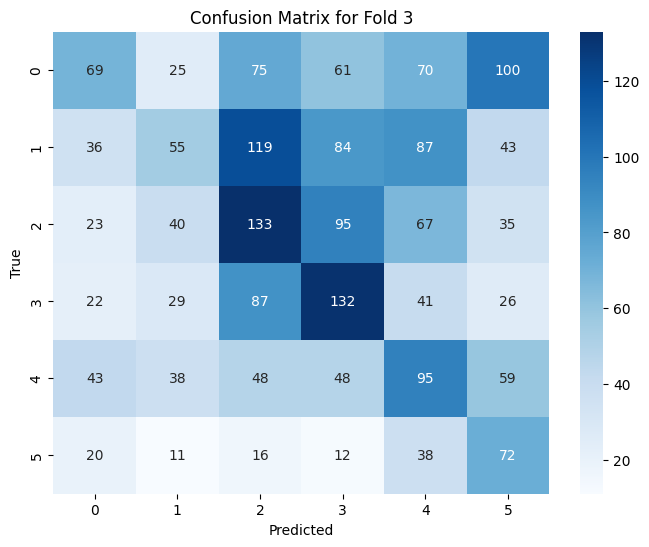

Classification Report for Fold 3:
              precision    recall  f1-score   support

           0       0.32      0.17      0.23       400
           1       0.28      0.13      0.18       424
           2       0.28      0.34      0.31       393
           3       0.31      0.39      0.34       337
           4       0.24      0.29      0.26       331
           5       0.21      0.43      0.29       169

    accuracy                           0.27      2054
   macro avg       0.27      0.29      0.27      2054
weighted avg       0.28      0.27      0.26      2054


Generating confusion matrix for Fold 4


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


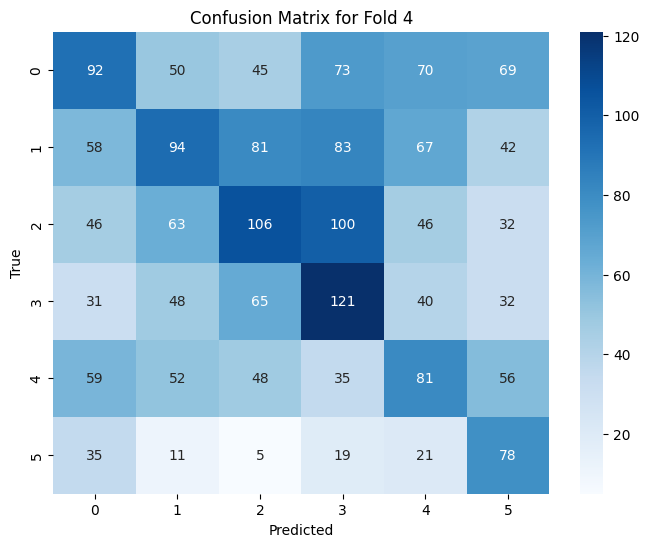

Classification Report for Fold 4:
              precision    recall  f1-score   support

           0       0.29      0.23      0.26       399
           1       0.30      0.22      0.25       425
           2       0.30      0.27      0.29       393
           3       0.28      0.36      0.32       337
           4       0.25      0.24      0.25       331
           5       0.25      0.46      0.33       169

    accuracy                           0.28      2054
   macro avg       0.28      0.30      0.28      2054
weighted avg       0.28      0.28      0.27      2054


Generating confusion matrix for Fold 5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


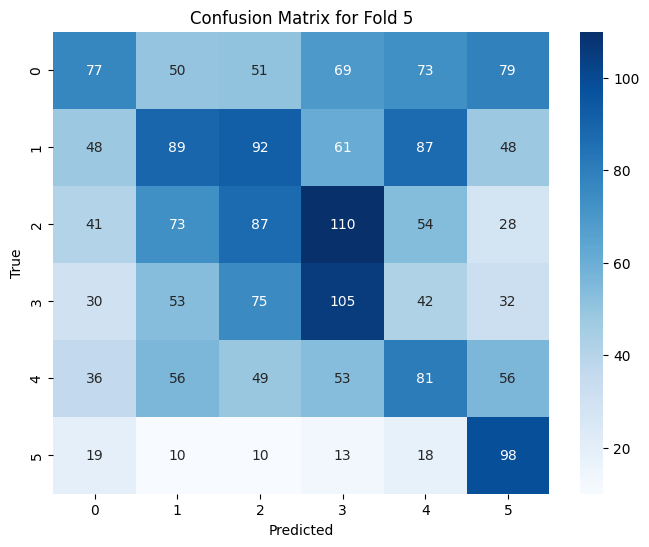

Classification Report for Fold 5:
              precision    recall  f1-score   support

           0       0.31      0.19      0.24       399
           1       0.27      0.21      0.24       425
           2       0.24      0.22      0.23       393
           3       0.26      0.31      0.28       337
           4       0.23      0.24      0.24       331
           5       0.29      0.58      0.39       168

    accuracy                           0.26      2053
   macro avg       0.26      0.29      0.27      2053
weighted avg       0.26      0.26      0.25      2053



In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to create the Keras model
def create_model(input_dim, num_classes, hidden_size=64, dropout_rate=0.3, l2_alpha=1e-4, learning_rate=1e-3):
    model = keras.Sequential([
        layers.InputLayer(input_shape=(input_dim,)),
        layers.Dense(hidden_size, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(l2_alpha)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(hidden_size, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(l2_alpha)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax',
                     kernel_regularizer=keras.regularizers.l2(l2_alpha))
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameters
hidden_size = 64
dropout_rate = 0.3
l2_alpha = 1e-4
learning_rate = 1e-3
batch_size = 128
epochs = 100

num_features = train_X_array.shape[1]  # Use the dense array
num_classes = len(np.unique(train_y))

# Initialize StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_y),
    y=train_y
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}
print("Class Weights:", class_weights_dict)

# Placeholders for results
acc_per_fold = []
loss_per_fold = []
histories = []

fold_no = 1
for train_index, val_index in skf.split(train_X_array, train_y):
    print(f'\nTraining for fold {fold_no} ...')
    
    # Split data
    X_train_fold, X_val_fold = train_X_array[train_index], train_X_array[val_index]
    y_train_fold, y_val_fold = train_y[train_index], train_y[val_index]
    
    # Feature Scaling
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)
    
    # Build and compile model
    model = create_model(input_dim=num_features,
                         num_classes=num_classes,
                         hidden_size=hidden_size,
                         dropout_rate=dropout_rate,
                         l2_alpha=l2_alpha,
                         learning_rate=learning_rate)
    
    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=1e-6
    )
    
    # Train the model
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    histories.append(history.history)
    
    # Evaluate the model
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} = {scores[0]:.4f}; {model.metrics_names[1]} = {scores[1]*100:.2f}%')
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no += 1

# Summarize results
print('\n------------------------------------------------------------------------')
print('Score per fold')
for i in range(len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]:.4f} - Accuracy: {acc_per_fold[i]:.2f}%')
print('------------------------------------------------------------------------')
print(f'Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold):.2f}% (+- {np.std(acc_per_fold):.2f}%)')
print(f'> Loss: {np.mean(loss_per_fold):.4f}')
print('------------------------------------------------------------------------')

# Visualization

# Plotting training and validation loss and accuracy for each fold
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i+1} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i+1} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Aggregate performance
metrics_df = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(n_splits)],
    'Accuracy': acc_per_fold,
    'Loss': loss_per_fold
})

# Boxplot for Accuracy
plt.figure(figsize=(8, 6))
sns.boxplot(x='Accuracy', data=metrics_df, palette='pastel')
plt.title('Cross-Validation Accuracy')
plt.xlabel('Accuracy (%)')
plt.show()

# Boxplot for Loss
plt.figure(figsize=(8, 6))
sns.boxplot(x='Loss', data=metrics_df, palette='muted')
plt.title('Cross-Validation Loss')
plt.xlabel('Loss')
plt.show()

# Barplot with Mean and Standard Deviation for Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Fold', y='Accuracy', data=metrics_df, ci='sd', palette='viridis')
plt.title('Accuracy per Fold with Standard Deviation')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.show()

# Barplot with Mean and Standard Deviation for Loss
plt.figure(figsize=(10, 6))
sns.barplot(x='Fold', y='Loss', data=metrics_df, ci='sd', palette='magma')
plt.title('Loss per Fold with Standard Deviation')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.show()

# Confusion Matrix for each fold
from sklearn.metrics import confusion_matrix, classification_report

for i, (train_index, val_index) in enumerate(skf.split(train_X_array, train_y)):
    print(f'\nGenerating confusion matrix for Fold {i+1}')
    
    # Split and scale data
    X_train_fold, X_val_fold = train_X_array[train_index], train_X_array[val_index]
    y_train_fold, y_val_fold = train_y[train_index], train_y[val_index]
    
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)
    
    # Rebuild and train the model
    model = create_model(input_dim=num_features,
                         num_classes=num_classes,
                         hidden_size=hidden_size,
                         dropout_rate=dropout_rate,
                         l2_alpha=l2_alpha,
                         learning_rate=learning_rate)
    
    # Train the model (without saving history)
    model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # Predict
    y_val_pred = model.predict(X_val_fold)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    
    # Confusion Matrix
    cm = confusion_matrix(y_val_fold, y_val_pred_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Fold {i+1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Classification Report
    print(f'Classification Report for Fold {i+1}:')
    print(classification_report(y_val_fold, y_val_pred_classes))
